In [1]:
import glob
import pandas as pd
from src.utils import map_category
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from datasets import load_from_disk


In [2]:
stream_data = load_from_disk("data/processed/stream_data")


In [3]:
stream_data.set_format(type="pandas")
train_df = stream_data["train"][:]
valid_df = stream_data["validation"][:]


In [4]:
X_train, y_train = train_df["text"], train_df["label"]
X_valid, y_valid = valid_df["text"], valid_df["label"]
labels = stream_data["train"].features["label"].names


In [5]:
vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
X_train = vectorizer.fit_transform(X_train)
X_valid = vectorizer.transform(X_valid)


In [6]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.utils.extmath import density
from time import time

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
   
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_valid)
    test_time = time() - t0
    print(f"inference time:  {test_time:.3}s")

    balanced_accuracy = balanced_accuracy_score(y_valid, pred)
    print(f"Balanced accuracy score:    {balanced_accuracy:.3}")

    macro_f1 = f1_score(y_valid, pred, average="macro")
    print(f"Macro F1 score:    {macro_f1:.3}")

    weighted_f1 = f1_score(y_valid, pred, average="weighted")
    print(f"Weighted F1 score:    {weighted_f1:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()
    
    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, balanced_accuracy, macro_f1, weighted_f1, train_time, test_time


In [7]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

results = []
for clf, name in (
    (LogisticRegression(class_weight="balanced"), "Logistic Regression"),
    (RidgeClassifier(class_weight="balanced"), "Ridge Classifier"),
    (KNeighborsClassifier(), "kNN"),
    (RandomForestClassifier(class_weight="balanced"), "RandomForest Classifier"),
    (LinearSVC(class_weight="balanced"), "Linear SVC"),
    (SGDClassifier(class_weight="balanced"), "SGD Classifier"),
    (NearestCentroid(), "NearestCentroid"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))
    

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(class_weight='balanced')
train time: 12.9s
inference time:  0.0159s
Balanced accuracy score:    0.631
Macro F1 score:    0.627
Weighted F1 score:    0.806
dimensionality: 10810
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(class_weight='balanced')
train time: 8.8s
inference time:  0.00233s
Balanced accuracy score:    0.646
Macro F1 score:    0.633
Weighted F1 score:    0.808
dimensionality: 10810
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.00248s
inference time:  0.454s
Balanced accuracy score:    0.493
Macro F1 score:    0.511
Weighted F1 score:    0.774

RandomForest Classifier
________________________________________________________________________________
Tra

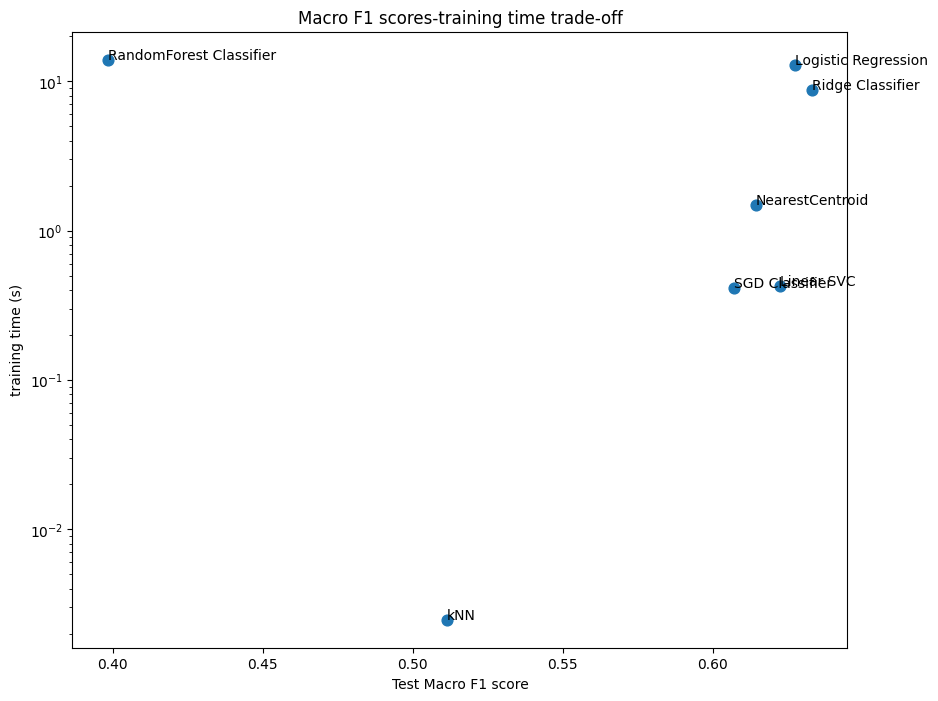

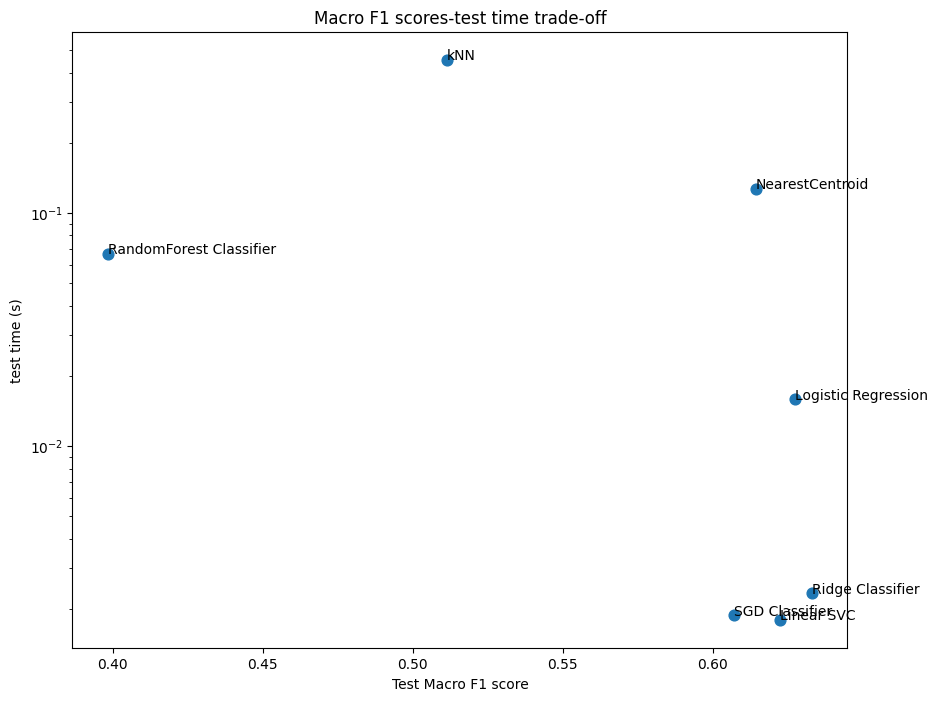

In [8]:
import numpy as np
import matplotlib.pyplot as plt  # Make sure matplotlib is imported

indices = np.arange(len(results))

# Extract all 5 elements from the results
results = [[x[i] for x in results] for i in range(6)]

# Unpack all 5 elements
clf_names, balanced_accuracy_scores, macro_f1_scores, weighted_f1_scores, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(macro_f1_scores, training_time, s=60)
ax1.set(
    title="Macro F1 scores-training time trade-off",
    yscale="log",
    xlabel="Test Macro F1 score",
    ylabel="training time (s)",
)

fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(macro_f1_scores, test_time, s=60)
ax2.set(
    title="Macro F1 scores-test time trade-off",
    yscale="log",
    xlabel="Test Macro F1 score",
    ylabel="test time (s)",
)


# Add text annotations to all plots
for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (macro_f1_scores[i], training_time[i]))
    ax2.annotate(txt, (macro_f1_scores[i], test_time[i]))


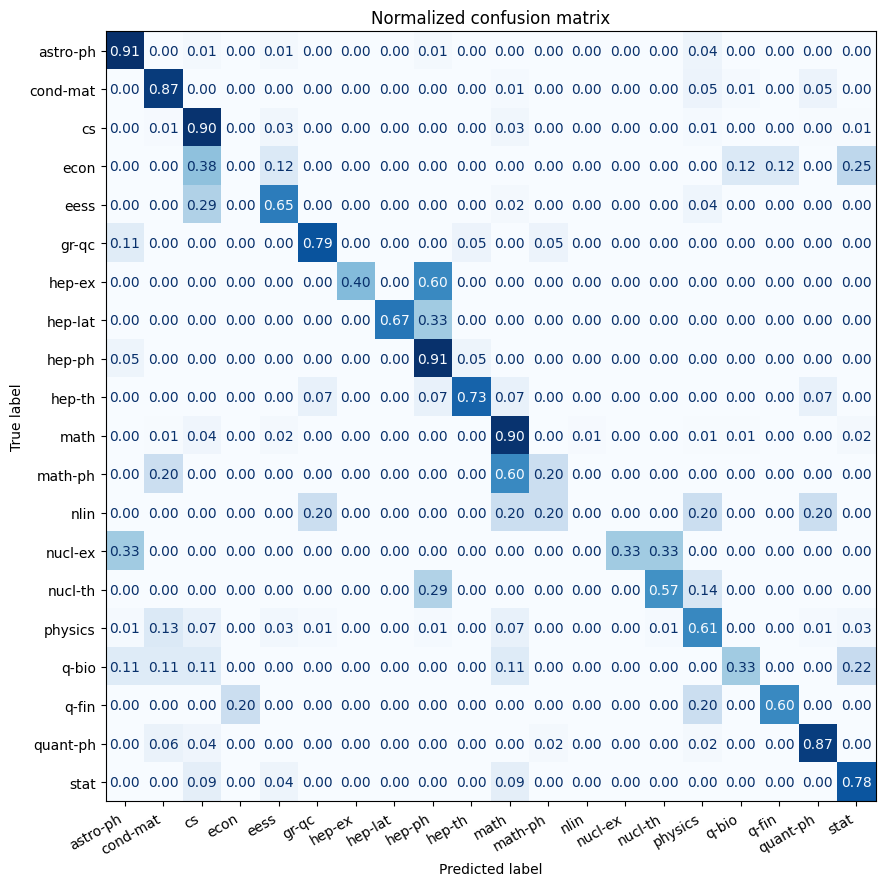

In [9]:
from src.utils import plot_confusion_matrix
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(class_weight="balanced", random_state=42)
svm_clf.fit(X_train, y_train)
y_preds = svm_clf.predict(X_valid)

plot_confusion_matrix(y_preds, y_valid, labels)


In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_preds, target_names=labels))


              precision    recall  f1-score   support

    astro-ph       0.91      0.91      0.91        70
    cond-mat       0.78      0.87      0.82        79
          cs       0.92      0.90      0.91       474
        econ       0.00      0.00      0.00         8
        eess       0.58      0.65      0.61        48
       gr-qc       0.83      0.79      0.81        19
      hep-ex       1.00      0.40      0.57         5
     hep-lat       1.00      0.67      0.80         3
      hep-ph       0.69      0.91      0.78        22
      hep-th       0.85      0.73      0.79        15
        math       0.85      0.90      0.88       191
     math-ph       0.25      0.20      0.22         5
        nlin       0.00      0.00      0.00         5
     nucl-ex       1.00      0.33      0.50         3
     nucl-th       0.67      0.57      0.62         7
     physics       0.68      0.61      0.64        71
       q-bio       0.50      0.33      0.40         9
       q-fin       0.75    